In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pyEXP
import gala.potential as gp
from gala.units import SimulationUnitSystem, galactic
import gala.dynamics as gd
import h5py

In [2]:
exp_units = SimulationUnitSystem(mass=1e10 * u.Msun, length=1 * u.kpc, G=1)

In [3]:
coefs_files = ['coefs_GC21_MW_DM_halo_10_8.h5', 'moving_coefs_GC21_MW_DM_halo_10_8.h5']

In [4]:
centers = np.zeros((258, 2))
j=0
for coef in coefs_files:
    cc = h5py.File(coef, mode='r+')
    snaps = list(cc['snapshots'].keys())
    i=0
    for snap in snaps[:258]:
        centers[i][j] = np.linalg.norm(cc['snapshots'][snap].attrs['Center'])
        i+=1
    j+=1
    cc.close()

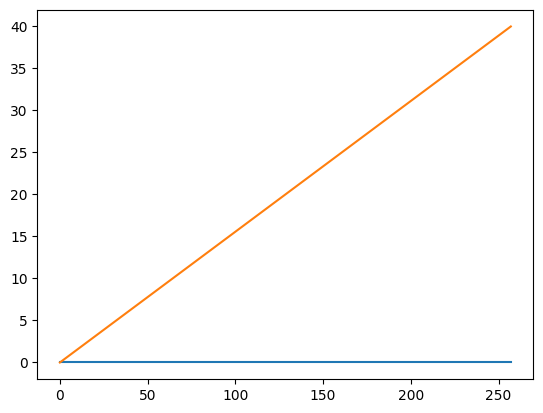

In [20]:
plt.plot(centers[:,0])
plt.plot(centers[:,1])


In [6]:
def gala_MW_potential(coefficients):
    MW_exp_pot = gp.EXPPotential(
        units=exp_units,
        config_file="./GC21_MW.yaml",
        coef_file = coefficients,
        snapshot_time_unit=u.Gyr,
        
    )
    MW_composite = gp.CCompositePotential()
    MW_composite['halo'] = MW_exp_pot
    MW_composite['disk'] = gp.MN3ExponentialDiskPotential(m=5.78e10*u.Msun, h_R=2.4*u.kpc, h_z=0.5*u.kpc, units=exp_units)
    MW_composite['bulge'] = gp.HernquistPotential(m=1.4e10*u.Msun, c=0.7*u.kpc, units=exp_units)

    return MW_composite

In [7]:
MW_pot = gala_MW_potential('coefs_GC21_MW_DM_halo_10_8.h5')

---- SLGridSph::ReadH5Cache: successfully read basis cache <cache_GC21_MW_DM_halo_10_8.h5>
---- Spherical::orthoTest: worst=0.121785


In [8]:
moving_MW_pot = gala_MW_potential('moving_coefs_GC21_MW_DM_halo_10_8.h5')

---- SLGridSph::ReadH5Cache: successfully read basis cache <cache_GC21_MW_DM_halo_10_8.h5>
---- Spherical::orthoTest: worst=0.121785


In [9]:
sim_test_particle = np.loadtxt('test_MW_orbit.txt')
sim_time = np.arange(0, len(sim_test_particle[:,0])*0.02, 0.02)

In [10]:
w0 = gd.PhaseSpacePosition(
    pos=[ -8.13596344,  68.09912872, -16.11926651] * u.kpc,
    vel=[  6.75677538, -74.71125031, -93.4519577 ] * u.km / u.s,
)
orbit = gp.Hamiltonian(MW_pot).integrate_orbit(w0, dt=0.01 * u.Myr, t1=0*u.Gyr, t2=2.2*u.Gyr)

In [11]:
com_mov_orbit = gp.Hamiltonian(moving_MW_pot).integrate_orbit(w0, dt=1 * u.Myr, t1=0*u.Gyr, t2=2.2*u.Gyr)

In [12]:
orb_distance = np.linalg.norm(orbit.xyz.to(u.kpc).value, axis=0)
orb_comp_distance = np.linalg.norm(com_mov_orbit.xyz.to(u.kpc).value, axis=0)
orb_sim_distance = np.linalg.norm(sim_test_particle[:,:3], axis=1)

orb_vel = np.linalg.norm(orbit.v_xyz.to(u.km/u.s).value, axis=0)
orb_comp_vel = np.linalg.norm(com_mov_orbit.v_xyz.to(u.km/u.s).value, axis=0)
orb_sim_vel = np.linalg.norm(sim_test_particle[:,3:], axis=1)

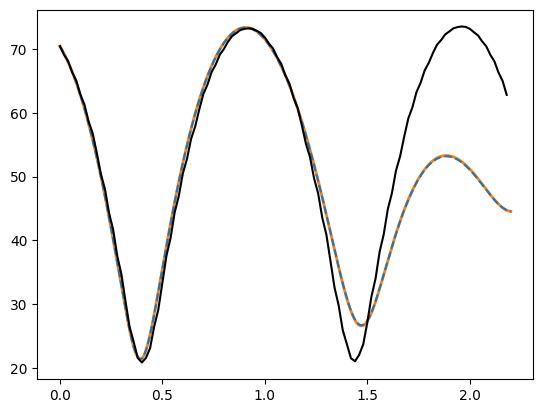

In [21]:
plt.plot(orbit.t.to(u.Gyr), orb_distance, ls='-', lw=2, c='C1', label='Gala without movig frame')
plt.plot(com_mov_orbit.t.to(u.Gyr), orb_comp_distance, ls='--', c='C0', label='Gala moving frame')
plt.plot(sim_time, orb_sim_distance, c='k', label='Gadget')